In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sn
import re

import tensorflow as tf 
import tensorflow.keras as keras 
import tensorflow_addons  as tfa

import sklearn.model_selection as model_selection
import sklearn.metrics as metrics_model
import sklearn.linear_model as linear_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/glove.6B.zip

Archive:  /content/drive/MyDrive/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS=stopwords.words('english')

def remove_hash(data):
  return re.sub('#','',data)

def remove_stop_word_less_than_3_charecter(data):
  min_stop=[w for w in STOPWORDS if len(w)<=3]
  word=data.split()
  res=[w for w in word if w not in min_stop]
  return ' '.join(res)

def remove_stop_word(data):
  word=data.split()
  res=[w for w in word if w not in STOPWORDS]
  return ' '.join(res)

# def remove_hash(data):
#   words=data.split()
#   res=[w for w in words if '#' not in w]
#   return ' '.join(res)

def clean(data):
  res=re.sub(r'[^a-zA-Z0-9#]',' ',data)
  #res=remove_stop_word(res)
  res=remove_hash(res)
  return res

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [5]:
train_set=pd.read_csv('/content/drive/MyDrive/train_df.csv')
test_set=pd.read_csv('/content/drive/MyDrive/test_df.csv')

train_set['clean_text_1']=train_set['clean_text'].apply(clean)
test_set['clean_text_1']=test_set['clean_text'].apply(clean)

train_set['word_number']=train_set['clean_text_1'].apply(lambda x:len(x.split()))
test_set['word_number']=test_set['clean_text_1'].apply(lambda x:len(x.split()))

train_set=train_set[train_set['word_number']!=0]
test_set=test_set[test_set['word_number']!=0]

X_train=train_set['clean_text_1'].values
X_test=test_set['clean_text_1'].values
y_train=train_set['NomericSentiment'].values
y_test=test_set['NomericSentiment'].values

X_train,X_val,y_train,y_val=model_selection.train_test_split(X_train,y_train,test_size=0.2,stratify=train_set['NomericSentiment'],random_state=42)

y_train=keras.utils.to_categorical(y_train,5)
y_test=keras.utils.to_categorical(y_test,5)
y_val=keras.utils.to_categorical(y_val,5)

tokinizer=keras.preprocessing.text.Tokenizer(num_words=30000)
tokinizer.fit_on_texts(train_set['clean_text_1'].values)

vocab_size=len(tokinizer.word_index)+1
print(vocab_size)

max_length=70
X_train=tokinizer.texts_to_sequences(X_train)
X_test=tokinizer.texts_to_sequences(X_test)
X_val=tokinizer.texts_to_sequences(X_val)
X_train_set=keras.preprocessing.sequence.pad_sequences(X_train,padding='post',maxlen=max_length)
X_test_set=keras.preprocessing.sequence.pad_sequences(X_test,padding='post',maxlen=max_length)
X_val_set=keras.preprocessing.sequence.pad_sequences(X_val,padding='post',maxlen=max_length)



40512


In [5]:
embading_index={}
path = '/content/glove.6B.300d.txt'
with open(path) as f:
  for line in f:
    key,value=line.split(maxsplit=1)
    value=np.fromstring(value,"f",sep=" ")
    embading_index[key]=value

print("Found {} word vector".format(len(embading_index)))

embading_dim=300
num_tokens=vocab_size
hit=0
miss=0

embading_matrix=np.zeros((num_tokens,embading_dim))

for word,value in tokinizer.word_index.items():
  embading_vector=embading_index.get(word)
  if embading_vector is not None:
      embading_matrix[value]=embading_vector
      hit+=1
  else:miss+=1
print("Hit : {} ,misses: {}".format(hit,miss))

Found 400000 word vector
Hit : 27398 ,misses: 13113


In [7]:
keras.backend.clear_session()
K = keras.backend
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z=keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=max_length)(inputs)
z = keras.layers.GRU(128,return_sequences=True)(z,mask=mask)
z = keras.layers.GRU(128,return_sequences=True)(z,mask=mask)
z = keras.layers.GlobalMaxPool1D()(z)
outputs=keras.layers.Dense(5,activation='softmax')(z)
Model=keras.Model(inputs=[inputs],outputs=[outputs])

In [8]:
LR_START = 0.0000001
LR_MIN = 0.000001
LR_MAX = 0.0008
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lr_schedule(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr


In [9]:
Model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=1e-4),metrics=['accuracy'])
eraly_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
check_point=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/GRU_Learning_scheduler_20.h5',save_best_only=True)
lr_scdual=keras.callbacks.LearningRateScheduler(lr_schedule,verbose=0)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 3,
  verbose = 0, mode = "auto", min_delta = 0.0008, cooldown = 0,
  min_lr = 1e-5)
callbacks_list=[eraly_stop,check_point,lr_scdual]


In [10]:
with tf.device('/device:GPU:0'):
  history=Model.fit(X_train_set,y_train,epochs=20,validation_data=(X_val_set,y_val),callbacks=callbacks_list)

Epoch 1/20
823/823 [==============================] - 115s 130ms/step - loss: 1.6400 - accuracy: 0.1890 - val_loss: 1.6355 - val_accuracy: 0.1849
Epoch 2/20
823/823 [==============================] - 109s 133ms/step - loss: 1.3884 - accuracy: 0.3831 - val_loss: 0.9186 - val_accuracy: 0.6470
Epoch 3/20
823/823 [==============================] - 108s 131ms/step - loss: 0.8136 - accuracy: 0.6896 - val_loss: 0.6918 - val_accuracy: 0.7547
Epoch 4/20
823/823 [==============================] - 107s 130ms/step - loss: 0.5428 - accuracy: 0.8121 - val_loss: 0.6289 - val_accuracy: 0.7677
Epoch 5/20
823/823 [==============================] - 108s 131ms/step - loss: 0.3610 - accuracy: 0.8832 - val_loss: 0.7289 - val_accuracy: 0.7383
Epoch 6/20
823/823 [==============================] - 105s 128ms/step - loss: 0.2393 - accuracy: 0.9281 - val_loss: 0.6948 - val_accuracy: 0.7613
Epoch 7/20
823/823 [==============================] - 105s 127ms/step - loss: 0.1552 - accuracy: 0.9561 - val_loss: 0.7966 -

Accuracy : 0.8869
Accuracy : 0.7774


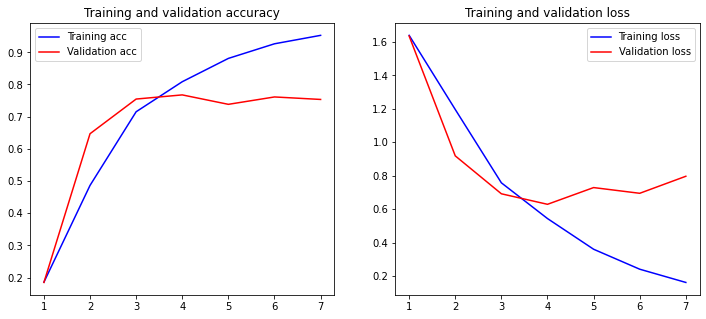

In [11]:
Model=keras.models.load_model('/content/drive/MyDrive/GRU_Learning_scheduler_20.h5')
loss,acc=Model.evaluate(X_train_set,y_train,verbose=False)
print("Accuracy : {:.4f}".format(acc))
loss,acc=Model.evaluate(X_test_set,y_test,verbose=False)
print("Accuracy : {:.4f}".format(acc))
plot_history(history)